In [1]:
import random
import scipy
import math

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from networkx.algorithms.community import k_clique_communities
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import louvain_communities, louvain_partitions

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import mutual_info_score

import community
from networkx.generators.community import LFR_benchmark_graph # here do not use algorithms, not really work /:(
from collections import Counter
from networkx.algorithms.community import modularity

plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1.0),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1.0),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1.0),  # blue  with alpha = 20%
})

# Part 1: Centrality [30 points]

### 1.1

In [2]:
def load_graphs():
    """
    
    Returns:
    G_airport: NetworkX Graph Object
    G_yeast: NetworkX Graph Object
    
    """
    # add file path for loading
    airport_file = "/Users/zklou/Desktop/Assignment3/US_airports.txt"
    yeast_file = "/Users/zklou/Desktop/Assignment3/Yeast.txt"
    
    # Load the airport network with weights from the 3rd column
    G_airport = nx.read_edgelist(airport_file, nodetype=int, data=(('weight', float),))
    
    # Load the yeast interaction network (assuming similar format)
    G_yeast = nx.read_edgelist(yeast_file, nodetype=int, data=(('weight', float),))
    
    return G_airport, G_yeast

### 1.2

In [3]:
def top_10_nodes(G):
    """
    Inputs:
    G: NetworkX Graph Object
    
    Returns:
    top_10_nodes_dict: dict[list[int]]
    
    """
    # Compute Eigenvector centrality
    # Set max_iter=2000 to ensure convergence, I was using 1k but not that good 
    eigen = nx.eigenvector_centrality(G, max_iter=2000)

    # Compute Katz centrality
    # The alpha value needs to be carefully chosen to ensure convergence
    try:
        # Calculate the largest eigenvalue of the adjacency matrix
        # This is used to adjust alpha for stability, was tried 0.8, 0.9 and 0.95 then found 95 is way better.
        largest_eigenvalue = max(np.linalg.eigvals(nx.adjacency_matrix(G).todense()).real)
        alpha_value = 0.95 / largest_eigenvalue  # Set alpha to ensure convergence
        katz = nx.katz_centrality(G, alpha=alpha_value, max_iter=3000)
    
    except nx.PowerIterationFailedConvergence:
        # If computation fails, decrease alpha and retry
        print(f"Warning: Katz centrality failed to converge with α = {alpha_value}, trying smaller α...")
        alpha_value *= 0.8  # Reduce alpha to improve convergence
        katz = nx.katz_centrality(G, alpha=alpha_value, max_iter=4000)
    
    except Exception as e:
        # Handle other exceptions to prevent crashes
        print("**** /:( Error computing Katz centrality:", e)
        katz = {}

    # Compute PageRank centrality
    page_rank = nx.pagerank(G)

    # Convert the weighted graph to an unweighted graph
    # This is required for closeness, harmonic, and betweenness calculations as out instrution says 
    G_unweighted = nx.Graph(G)

    # Compute the largest connected component (LCC)
    # Many centrality measures require a connected graph, so we extract the LCC
    largest_cc = max(nx.connected_components(G_unweighted), key=len)
    G_largest = G_unweighted.subgraph(largest_cc)

    # Compute Closeness centrality
    # Only computed on the largest connected component with wf_improved=True for better accuracy
    closeness = nx.closeness_centrality(G_largest, wf_improved=True)

    # Compute Harmonic centrality
    # Also calculated on the largest connected component
    harmonic = nx.harmonic_centrality(G_largest)

    # Compute Betweenness centrality (unweighted)
    # Since this computation is costly, we use an unweighted graph to reduce complexity
    betweenness = nx.betweenness_centrality(G_unweighted)

    # Sort and select the top 10 nodes for each centrality measure
    top_10_nodes_dict = {
        'eigen': sorted(eigen, key=eigen.get, reverse=True)[:10],
        'katz': sorted(katz, key=katz.get, reverse=True)[:10] if katz else [],
        'page_rank': sorted(page_rank, key=page_rank.get, reverse=True)[:10],
        'closeness': sorted(closeness, key=closeness.get, reverse=True)[:10],
        'harmonic': sorted(harmonic, key=harmonic.get, reverse=True)[:10],
        'betweenness': sorted(betweenness, key=betweenness.get, reverse=True)[:10],
    }

    return top_10_nodes_dict


### 1.3

In [4]:
def calculate_similarity_matrix(top_nodes_dict):
    """
    Inputs:
    top_nodes_dict: dict[list[int]]
    
    Returns:
    similarity_matrix: np.array
    """
    # Extract centrality measure names
    centralities = list(top_nodes_dict.keys())
    n = len(centralities)
    
    # Initialize the similarity matrix (symmetric) to store Jaccard similarity values
    similarity_matrix = np.zeros((n, n))

    # Compute Jaccard similarity for each pair of centrality measures
    for i, measure_1 in enumerate(centralities):
        for j, measure_2 in enumerate(centralities):
            # Convert top 10 node lists into sets for comparison
            set_1 = set(top_nodes_dict[measure_1])
            set_2 = set(top_nodes_dict[measure_2])
            
            # Jaccard similarity formula: |A and B| / |A by B|
            intersection = len(set_1 & set_2)
            union = len(set_1 | set_2)

            # Store the similarity score, avoiding division by zero
            similarity_matrix[i, j] = intersection / union if union != 0 else 0.0

    return similarity_matrix

def plot_similarity_heatmap(similarity_matrix, data_name, save=False):
    """
    Inputs:
    similarity_matrix: np.array
    data_name: str
    """
    plt.figure(figsize=(7, 7))

    # Define centrality measure labels for the heatmap axes
    centrality_labels = [
        "Eigen-vector", "Katz", "PageRank", "Closeness", "Harmonic", "SP Betweenness"
    ]

    # Generate a heatmap using seaborn with Jaccard similarity values
    ax = sns.heatmap(
        similarity_matrix, 
        annot=True,  # Show numerical values inside each cell for easier comparison
        fmt=".3f",  # Keep three decimal places to capture finer differences in similarity
        cmap="Greens",  # Chosen because it is colorblind-friendly and has good contrast
        vmin=0, vmax=1,  # Jaccard similarity always falls in the range [0,1], ensuring consistency
        xticklabels=centrality_labels, yticklabels=centrality_labels,
        cbar_kws={'label': 'Jaccard Similarity Index'}  # Label the color bar to clarify meaning
    )

    # Adjust x-axis labels for better readability according to the pdf file
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.xticks(rotation=-45, ha="right")
    plt.yticks(fontsize=12)

    # Set title
    plt.title(f"Jaccard Similarity Matrix for {data_name}")

    plt.show()
    
    if save:
        plt.savefig(f'{data_name}_similarity_matrix.png')
    
    plt.close()


### 1.4

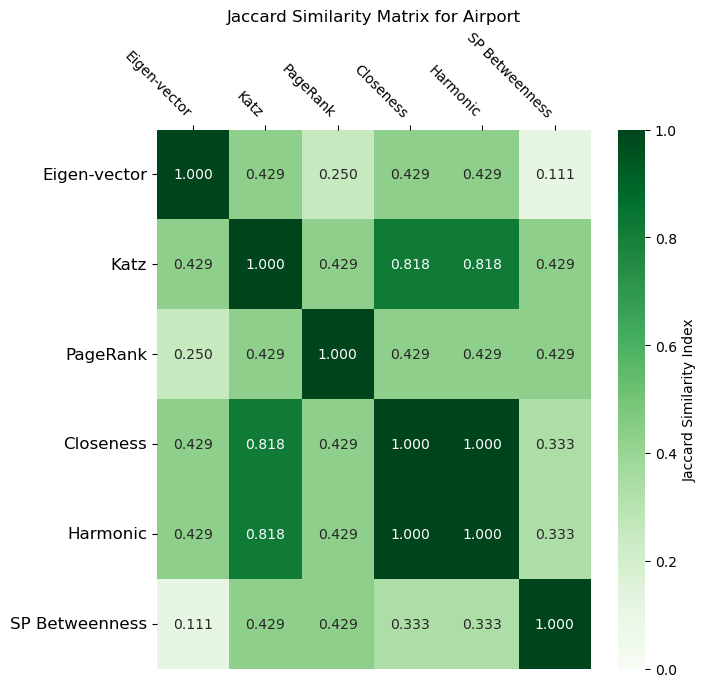

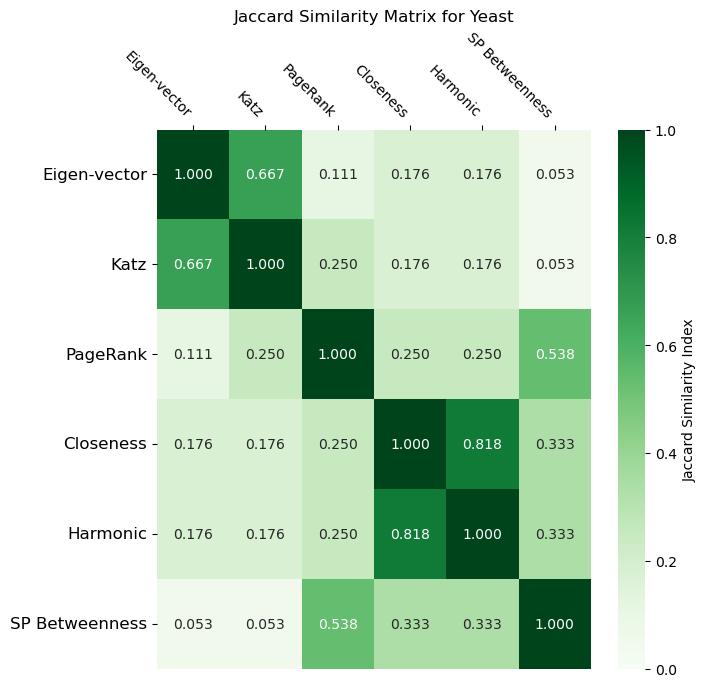

In [5]:
# Load the networks
G_airport, G_yeast = load_graphs()

# Get the top nodes
top_airport_nodes = top_10_nodes(G_airport)
top_yeast_nodes = top_10_nodes(G_yeast)

# Generate the similarity matrcies
node_similarity_airport = calculate_similarity_matrix(top_airport_nodes)
node_similarity_yeast = calculate_similarity_matrix(top_yeast_nodes)

# Generate the heatmaps
plot_similarity_heatmap(node_similarity_airport, 'Airport')
plot_similarity_heatmap(node_similarity_yeast, 'Yeast')


## Written Response for 1.4

Answer: 
##### Based on the L6, I will say for the undirected weighed airport network, the Strength Centrality would be the most relevant. Since it is undirected and weighed, SC would be able to help balance the airports connections and overall flow and flight numbers. Also the higher SC is, the more it show that have high caplacity for connections. 
##### Fot the directed and unweighted Yeast network, the PageRank would be most relavent, due to it's directed, PageRank can help to calculatethe importance for nodes by recursion, help to cahtch those important nodes in the network.


# Part 2: Community Detection with Zachary’s Karate Club [25 points]

### 2.1

In [6]:
def compute_cfinder_communities(G, k):
    """
    Inputs:
    G: NetworkX Graph Object
    k: Size of the clique for k-clique percolation method

    Returns:
    community_assignments: list[int]
    """
    # Apply k-clique percolation to detect communities
    communities = list(k_clique_communities(G, k))
    node_community_map = {}
    multiple_community_label = len(communities)  # Extra label for nodes in multiple communities

    # Assign community labels to nodes
    for i, community in enumerate(communities):
        for node in community:
            if node in node_community_map:
                node_community_map[node] = multiple_community_label  # Assign special category
            else:
                node_community_map[node] = i
    
    # Create a list of community assignments for all nodes
    community_assignments = [node_community_map.get(node, -1) for node in G.nodes()]
    return community_assignments

def compute_greedy_communities(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    # Apply greedy modularity optimization to find communities
    communities = list(greedy_modularity_communities(G))
    node_community_map = {}
    multiple_community_label = len(communities)

    # Assign community labels to nodes
    for i, community in enumerate(communities):
        for node in community:
            if node in node_community_map:
                node_community_map[node] = multiple_community_label  # Assign multi-community label
            else:
                node_community_map[node] = i
    
    # Create a list of community assignments for all nodes
    community_assignments = [node_community_map.get(node, -1) for node in G.nodes()]
    return community_assignments

def compute_louvain_communities(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns:
    community_assignments: list[int]
    """
    # Apply the Louvain method to detect communities
    partition = community.best_partition(G)
    
    # Convert the partition dictionary into a list of assignments
    community_assignments = [partition.get(str(node), partition.get(int(node), -1)) for node in G.nodes()]
    return community_assignments


### 2.2

In [7]:
def plot_network_communities(G, community_assignments, algorithm_name, save=False):
    """
    Inputs:
    G: NetworkX Graph Object
    community_assignments: list[int]
    algorithm_name: str
    """
    random.seed(1)
    np.random.seed(1)

    # Get unique community labels from assignments
    communities = set(community_assignments)
    
    # Use a categorical colormap with enough distinct colors for communities
    color_map = plt.get_cmap("tab20", len(communities))
    community_colors = {community: color_map(i) for i, community in enumerate(communities)}

    # Handle nodes that were not assigned to any community (-1)
    if -1 not in community_colors:
        community_colors[-1] = 'black'  # Unclassified nodes are set to black to make it easier to check
    
    # Assign node colors based on their community assignment
    node_colors = [community_colors[community] for community in community_assignments]
    
    # Generate graph layout using spring layout for better visualization
    pos = nx.spring_layout(G, seed=42)  # Set seed for reproducibility
    
    plt.figure(figsize=(5, 5))
    
    # Draw the network with assigned colors
    nx.draw(G, pos, node_size=300, with_labels=True, node_color=node_colors, 
            font_size=10, font_weight='bold', edge_color='gray')
    
    # Add title
    plt.title(f'{algorithm_name} - Network Communities', fontsize=14)
    
    plt.show()
    if save:
        plt.savefig(f'karate_communities_{algorithm_name}.png')
    plt.close()


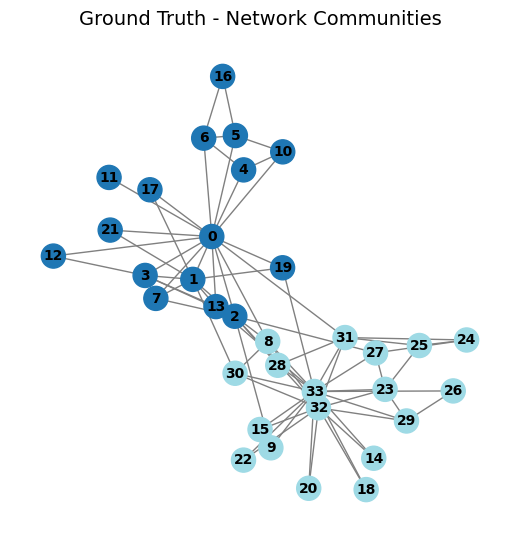

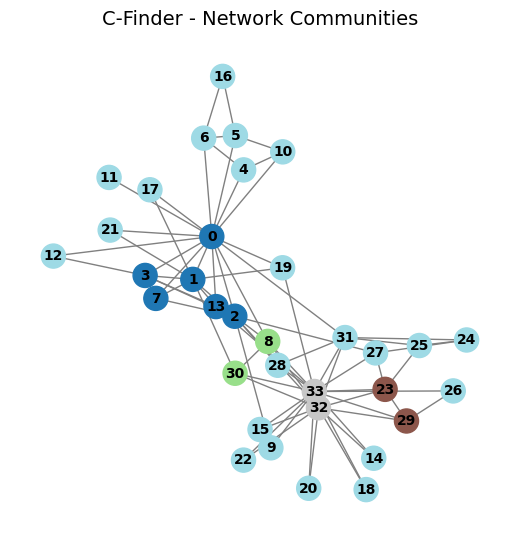

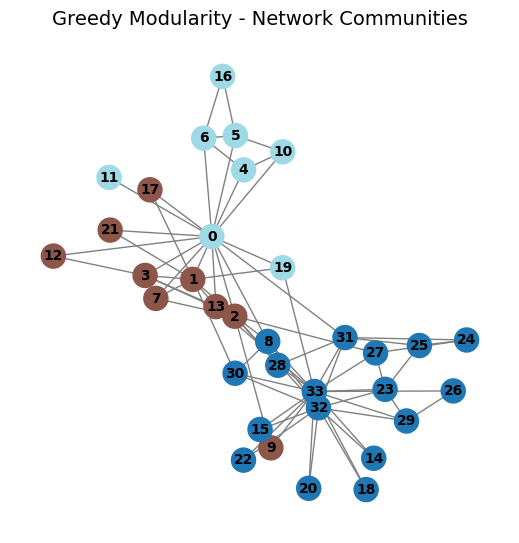

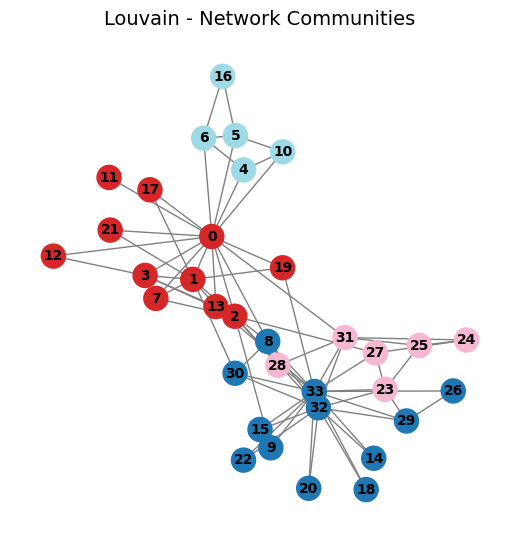

In [8]:
def select_k_for_cfinder(G):
    
    # Get the number of nodes and calculate the density of the graph
    n = G.number_of_nodes()
    density = nx.density(G)
    
    max_valid_k = None
    best_k = 3  # Default k value based on empirical testing

    # k values and their corresponding network properties
    # k=5: Too large, misses many nodes, suitable for very dense networks
    # k=4: Moderate, but some nodes remain unassigned, works for semi-dense networks
    # k=3: Best match for Karate Club, ideal for networks like this
    # k=2: Over-segmentation, too many communities, suitable for very sparse networks

    # Compute critical density for different k values to find the largest valid k
    for k in range(3, min(10, n // 5)):  # Limit max k to prevent overflow
        p_critical = np.power(n, -1.0 / (k - 1))
        
        if density > p_critical:
            max_valid_k = k  # Update max valid k
        else:
            break  # Stop when the graph density is lower than the threshold


G = nx.karate_club_graph()

# Automatically select k based on graph properties
k = select_k_for_cfinder(G)

ground_truth = [0, 0, 0, 0, 0, 
                0, 0, 0, 1, 1, 
                0, 0, 0, 0, 1, 
                1, 0, 0, 1, 0, 
                1, 0, 1, 1, 1,
                1, 1, 1, 1, 1,
                1, 1, 1, 1]


# Chose a reasonable value for k in the cfinder algorithm 
cfinder_assignments = compute_cfinder_communities(G, k=4)
greedy_assignments = compute_greedy_communities(G)
louvain_assignments = compute_louvain_communities(G)


# Compare resulting community assignments with the ground truth
plot_network_communities(G, ground_truth, 'Ground Truth')
plot_network_communities(G, cfinder_assignments, 'C-Finder')
plot_network_communities(G, greedy_assignments, 'Greedy Modularity')
plot_network_communities(G, louvain_assignments, 'Louvain')



## Written Response for 2.3

Answer:
##### As above shows Louvian is the most match one between those network communities with Ground Truth as a standard(if you want say which is the best between those four, it is Ground Truth), the Louvian have most core nodes compare to others, such as 5, 6, 10 , 17 and so on. Also Louvian keeped community logical. Besides those Louvian made a balanced approach with better optimizaton.

##### Also those are all pretty outstanding result but between those, C-Finder would be the worst one, it produces a lot fragmented or inconsistent community structures, have a lot different kinds of communities exist in the graph. Also, there are some nodes like 8, 30 should be in the same community in other groups so it also create some overlapping or hierarchical communities.

# Part 3: Community Detection with LFR Networks [25 points]

### 3.1

In [9]:
# Generating the LFR Benchmark Network
def generate_lfr_benchmark(mu):
    """
    Inputs:
    mu: float

    Returns:
    G: NetworkX Graph Object
    community_assignments: list[int]
    """
    
    n = 500
    tau1 = 2.5
    tau2 = 2
    min_degree = 3
    min_community = 40
    seed = 10
    
    # Ensure mu is within a reasonable range to avoid extreme results
    # If mu is too low, the network is too clustered; if too high, communities are indistinguishable
    mu = max(0.1, min(1.0, mu))
    
    # Generate the LFR benchmark graph with the specified parameters
    G = nx.LFR_benchmark_graph(
        n, tau1=tau1, tau2=tau2, mu=mu,
        min_degree=min_degree,
        min_community=min_community,
        seed=seed
    )
    
    # Assign unique integer labels to each detected community
    node_to_community = {}
    community_id = 0  # Community index counter
    
    for node in G.nodes():
        for comm in G.nodes[node]['community']:  # Each node may belong to multiple communities
            if comm not in node_to_community:
                node_to_community[comm] = community_id  # Assign a new unique ID to the community
                community_id += 1
        
        # Ensure every node is assigned a valid community label
        if G.nodes[node]['community']:
            G.nodes[node]['community'] = node_to_community[next(iter(G.nodes[node]['community']))]
        else:
            G.nodes[node]['community'] = -1  # Assign -1 for unclassified nodes
    
    # Extract final community assignments for each node
    community_assignments = [G.nodes[node]['community'] for node in G.nodes()]
    
    return G, community_assignments


### 3.2

In [10]:
def normalized_mutual_information(y_true, y_pred):
    """
    Inputs:
    y_true: list[int]
    y_pred: list[int]

    Returns:
    NMI: float
    """
    # Compute entropy H(U) and H(V)
    def entropy(labels):
        label_counts = Counter(labels)
        total = len(labels)
        return -sum((count / total) * np.log2(count / total) for count in label_counts.values())

    # Compute mutual information I(U, V)
    true_counts = Counter(y_true)
    pred_counts = Counter(y_pred)
    total = len(y_true)
    
    joint_counts = Counter(zip(y_true, y_pred))
    mi = sum(
        (count / total) * np.log2((count / total) / (true_counts[u] / total * pred_counts[v] / total))
        for (u, v), count in joint_counts.items()
    )

    # Compute NMI
    H_true = entropy(y_true)
    H_pred = entropy(y_pred)

    NMI = 2 * mi / (H_true + H_pred) if (H_true + H_pred) > 0 else 0.0
    return NMI

### 3.3

In [11]:
def sweep_mu_values():
    """
    
    Returns:
    greedy_nmis: list[float]
    louvain_nmis: list[float]
    
    """
    greedy_nmis = []
    louvain_nmis = []

    # Define mu values from 0.1 to 1.0, ensuring 10 equally spaced points
    mu_values = np.linspace(0.1, 1.0, 10)
    
    for mu in mu_values:
        try:
            # Generate LFR benchmark graph and ground truth community labels
            G, ground_truth = generate_lfr_benchmark(mu)

            # Handle cases where ground truth is empty
            if not ground_truth:
                print(f"Warning: Empty community labels for mu={mu}")
                greedy_nmis.append(np.nan)
                louvain_nmis.append(np.nan)
                continue

            # Compute Greedy Modularity community assignments
            greedy_assignments = compute_greedy_communities(G)
            greedy_assignments = [c if c != -1 else 0 for c in greedy_assignments]  # Avoid -1 affecting NMI
            greedy_nmi = normalized_mutual_information(ground_truth, greedy_assignments)
            greedy_nmis.append(greedy_nmi)

            # Compute Louvain community assignments
            louvain_assignments = compute_louvain_communities(G)
            louvain_assignments = [c if c != -1 else 0 for c in louvain_assignments]  # Avoid -1 affecting NMI
            louvain_nmi = normalized_mutual_information(ground_truth, louvain_assignments)
            louvain_nmis.append(louvain_nmi)

        except Exception as e:
            print(f"Error processing mu={mu}: {e}")
            greedy_nmis.append(np.nan)  # Ensure consistent data structure
            louvain_nmis.append(np.nan)
            continue

    return greedy_nmis, louvain_nmis


### 3.4

In [12]:
def plot_nmi_values(greedy_nmis, louvain_nmis, save=False):
    """
    Inputs:
    greedy_nmis: list[int]
    louvain_nmis: list[int]
    """
    # Ensure `mu_values` matches the points generated in `sweep_mu_values()`
    mu_values = np.linspace(0.1, 1.0, 10)

    if len(greedy_nmis) != len(mu_values) or len(louvain_nmis) != len(mu_values):
        print(f"Error: The length of greedy_nmis ({len(greedy_nmis)}) or louvain_nmis ({len(louvain_nmis)}) does not match mu_values ({len(mu_values)}).")
        return

    greedy_nmis = np.array(greedy_nmis)
    louvain_nmis = np.array(louvain_nmis)
    mu_values = np.array(mu_values)

    # Identify NaN values
    greedy_nan_mask = np.isnan(greedy_nmis)
    louvain_nan_mask = np.isnan(louvain_nmis)

    # Create a new figure
    plt.figure(figsize=(8, 6))

    # Plot Greedy Modularity NMI values
    plt.plot(mu_values, greedy_nmis, label='Greedy Modularity', marker='o', linestyle='-', color='b')

    # Mark NaN points for Greedy
    if np.any(greedy_nan_mask):
        plt.scatter(mu_values[greedy_nan_mask], greedy_nmis[greedy_nan_mask], color='gray', marker='o', label='Greedy (Failed)')

    # Plot Louvain NMI values
    plt.plot(mu_values, louvain_nmis, label='Louvain', marker='x', linestyle='--', color='r')

    # Mark NaN points for Louvain
    if np.any(louvain_nan_mask):
        plt.scatter(mu_values[louvain_nan_mask], louvain_nmis[louvain_nan_mask], color='gray', marker='x', label='Louvain (Failed)')

    # Add labels and title
    plt.xlabel('Mu (Mixing Parameter)', fontsize=12)
    plt.ylabel('Normalized Mutual Information (NMI)', fontsize=12)
    plt.title('NMI Comparison: Greedy Modularity vs Louvain', fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='best', fontsize=10)

    plt.show()
    
    if save:
        plt.savefig('3_4.png')
    plt.close()


### 3.5

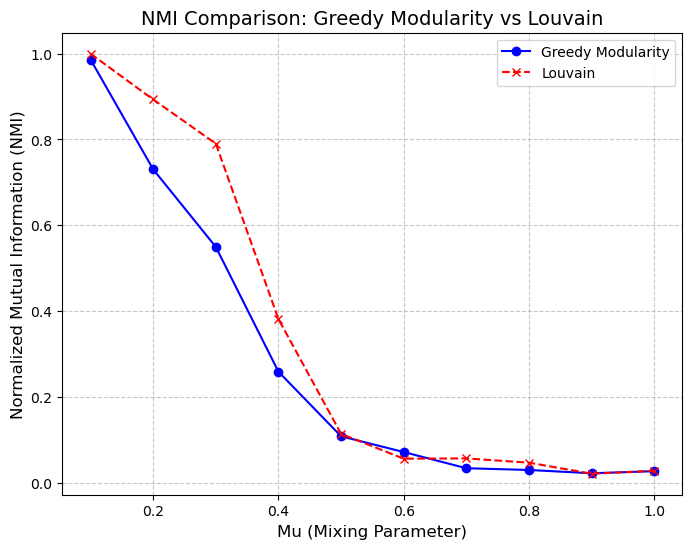

In [13]:
greedy_nmis, louvain_nmis = sweep_mu_values()

plot_nmi_values(greedy_nmis, louvain_nmis)

## Written Response for 3.5

Answer:
##### For Greedy, it descrese at a stable speed from low Mu till around Mu =0.5 Louvian have much better performance before Mu=0.3, after that it is still better than Greedy however they are become basic same after Mu = 0.5; 
##### For NMI, higher one close to Ground Truth stucture.
##### Mu can change the ability for those two algorithms, before 0.3 they both doing while and Louvian is better, after 0.5 Mu reducing the algorithm performance. For Mu=1 basiclly there no meaningful community structure remains.
##### However they both pretty good algothems can have differenct field to apply

# Part 4: Community Detection on Real World Data [15 points]

### 4.1

In [14]:
def calculate_community_sizes(G):
    """
    Inputs:
    G: NetworkX Graph Object

    Returns: 
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    """
    # Compute community sizes for Greedy Modularity
    greedy_communities = list(greedy_modularity_communities(G))
    greedy_sizes = [len(community) for community in greedy_communities]

    # Ensure the graph is undirected for Louvain method
    if isinstance(G, nx.DiGraph):
        G = G.to_undirected()

    # Compute community sizes for Louvain method
    G_louvain = G.copy()
    partition = community.best_partition(G_louvain)

    # Convert partition dictionary to a list of communities
    community_dict = {}
    for node, comm in partition.items():
        community_dict.setdefault(comm, set()).add(node)
    louvain_comms = list(community_dict.values())
    
    louvain_sizes = [len(community) for community in louvain_comms]

    return greedy_sizes, louvain_sizes


### 4.2

In [15]:
def plot_community_size_distributions(greedy_sizes, louvain_sizes, data_name, save=False):
    """
    Inputs:
    greedy_sizes: list[int]
    louvain_sizes: list[int]
    data_name: str
    """
    # Count occurrences of each unique community size
    greedy_unique, greedy_counts = np.unique(greedy_sizes, return_counts=True)
    louvain_unique, louvain_counts = np.unique(louvain_sizes, return_counts=True)
    
    plt.figure(figsize=(8,6))
    
    # Scatter plot for Greedy Modularity community sizes
    plt.scatter(greedy_unique, greedy_counts, color='b', label='Greedy Modularity', alpha=0.6)
    
    # Scatter plot for Louvain community sizes
    plt.scatter(louvain_unique, louvain_counts, color='r', label='Louvain', alpha=0.6)
    
    # Adjust x-axis range to prevent excessive whitespace
    plt.xlim(1, max(max(greedy_sizes), max(louvain_sizes)) * 1.1)
    plt.yscale("log")  # Use log scale to highlight differences in frequency
    plt.xscale("log")  # Log scale for better community size distribution representation
    
    # Add axis labels and title
    plt.xlabel('Community Size (log scale)', fontsize=12)
    plt.ylabel('Frequency (log scale)', fontsize=12)
    plt.title(f'Community Size Distributions: {data_name}', fontsize=14)
    
    # Add legend for clarity
    plt.legend()
    
    plt.grid(True, which="both", linestyle="--", alpha=0.6)
    plt.show()
    
    if save:
        plt.savefig('4_2.png')
    plt.close()


# After tried Histogram, violin and scatter plot, Scatter can display the community size and disctrbutions way better than others.

### 4.3

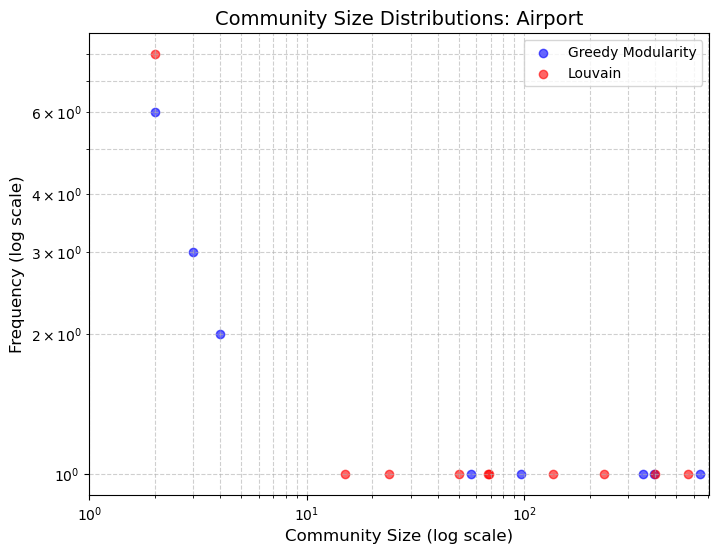

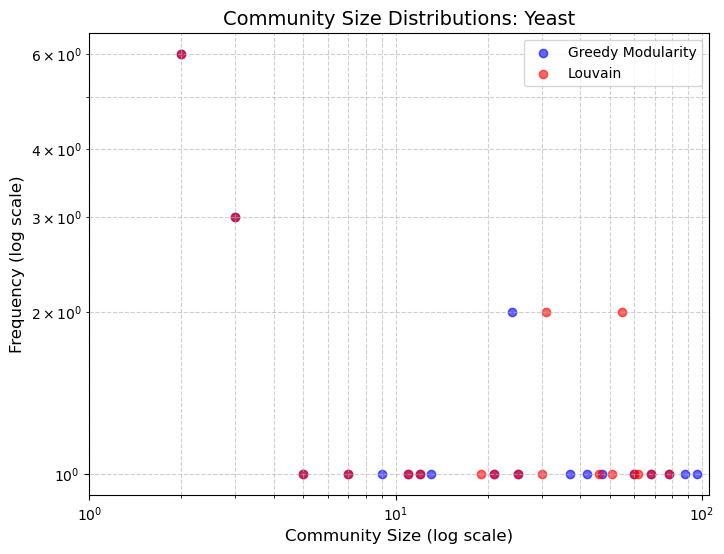

In [16]:
G_airport, G_yeast = load_graphs()

# Airport
greedy_sizes, louvain_sizes = calculate_community_sizes(G_airport)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Airport')

# Yeast
greedy_sizes, louvain_sizes = calculate_community_sizes(G_yeast)
plot_community_size_distributions(greedy_sizes, louvain_sizes, 'Yeast')

## Written Response for 4.3

Answer:
##### Compare and contrast : Airport vs Yeast, Greedy vs Louvian
#### Airport Plot: 
##### Greedy Modularity (blue) and Louvain (red) have similar distributions, but Louvain identifies more smaller communities.
##### Both algorithms detect a small number of large communities (right side of the graph) and a large number of small communities (left side of the graph).
##### Greedy Modularity appears to detect fewer small communities and is more likely to merge nodes into larger communities.
##### The presence of large communities suggests that both algorithms detect hierarchical or strongly connected clusters in the airport network.
#####
#### Yeast Plot:
##### The overall pattern of the yeast network is similar to that of the airport network, but the variation in community size is greater.
##### Louvain detects more small communities than Greedy.
##### The overall larger community sizes detected by Greedy Modularity suggest that it is more inclined to merge communities.
##### Louvain identifies multiple small, high-frequency communities, suggesting that it may be more sensitive to modular structure in the yeast network.
#####
##### About the distributionsLouvain tends to identify smaller communities, while Greedy Modularity forms larger communities.
##### The community size distribution of both networks resembles a power law distribution, i.e., most communities are small, but there are also a few large communities.
##### The airport network contains more large communities, while the community size of the yeast network varies more.
##### Louvain's more frequent small communities indicate that it is more refined, while Greedy Modularity tends to merge small communities to form larger groups.
##### 
##### According to those, in my opinion, The Louvain method is more suitable for identifying fine-scale small communities and is suitable for networks with complex structures.
##### Greedy Modularity tends to form larger communities and is suitable for detecting global clustering structures.
##### From the perspective of community size distribution, the Louvain method may be more suitable for networks with hierarchical or modular structures, while Greedy Modularity is more suitable for more holistic community structures.

## Response for 5



### Partition 1: All nodes are in the same community.

Image: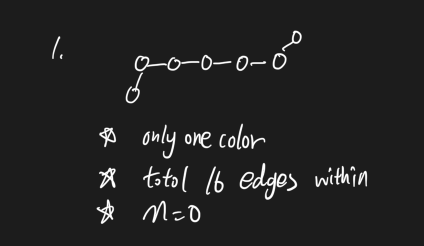

Modularity: 0.0

### Partition 2: Each node is in a community by itself.

Image: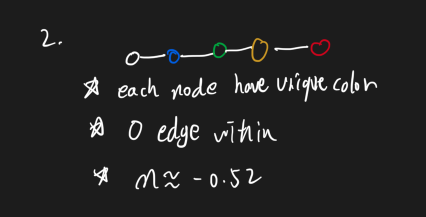

Modularity: -0.52

### Partition 3: Each community is composed of nodes that have no intra-community edges.

Image: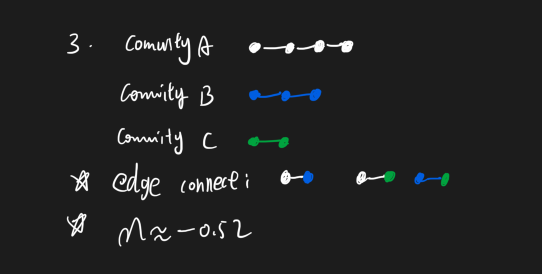

Modularity: -0.52

### Partition 4: A partition in which there are no inter-community edges.

Image: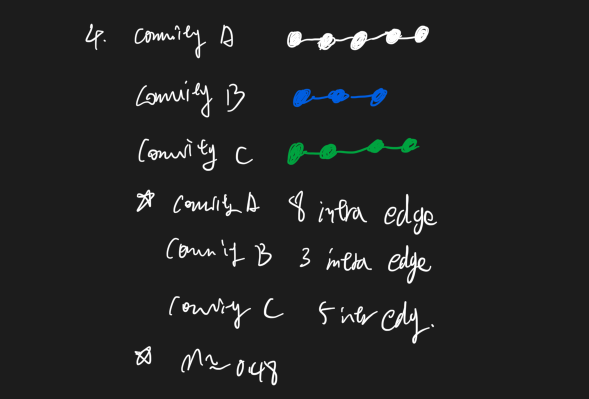

Modularity: 0.48